In [29]:
import sys
sys.path.append('../../../../../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
import matplotlib.pyplot as plt
from matplotlib import rc


In [30]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 6  # Number of execution scenarios                     (chi)
M = 1e3  # Big M

loc6_varying_factor = pandas.DataFrame(data={'com1_process': [0]*6})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

In [31]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================
com1_pur = Resource(name='com1_pur', cons_max=75, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [32]:
# prod_max = {0:60, 1: 120, 2: 150}
# prod_min = {0:0, 1: 60, 2: 120}
# rate_max = {0:4, 1:2, 2:1}

prod_max = {0:30, 1: 60, 2: 90, 3: 120, 4: 150}
prod_min = {0:0, 1: 30, 2: 60, 3: 90, 4: 120}
rate_max = {0:1.25, 1: 1, 2: 0.75, 3: 0.5, 4: 0.25}
mode_ramp = {(0,1): 5, (1,2): 5}

In [33]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_process_capacity = 125

com1_procure = Process(name='procure com1', prod_max=125, conversion={com1_pur: -1, com1_in: 1}, capex=0.01, vopex=0.01, prod_min=125, label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}, 3:{com1_in: -1, com1_out: 1}, 4:{com1_in: -1, com1_out: 1}},  capex=0.01, vopex=0.01, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

# com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}},  capex=0.01, vopex=0.01, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=com1_process_capacity, capex=100, vopex=1, store_min=0.01, store_max= 20, prod_min=com1_process_capacity, label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)
com1_store20 = Process(name='com1_store20', prod_max=com1_process_capacity, capex=200, vopex=2, store_min=0.01,store_max= 40, prod_min=com1_process_capacity, label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)
com1_store50 = Process(name='com1_store50', prod_max=com1_process_capacity, capex=500, vopex=5, store_min=0.01, store_max= 100, prod_min=com1_process_capacity, label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 7')

In [34]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={com1_process: loc6_varying_factor[['com1_process']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

In [35]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck_cap12 = 70
truck_cap13 = 30
truck_cap24 = 50
truck_cap25 = 30
truck_cap34 = 30
truck_cap45 = 100
truck_cap47 = 40
truck_cap64 = 50
truck_cap75 = 40

truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5, vopex=0.05, trans_min=truck_cap12)
truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_cap12)

truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3, vopex=0.03, trans_min=truck_cap13)
truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_cap13)

truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap24)
truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_cap24)

truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3, vopex=0.03, trans_min=truck_cap25)
truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_cap25)

truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2, vopex=0.02, trans_min=truck_cap34)
truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_cap34)

truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1, vopex=0.1, trans_min=truck_cap45)
truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_cap45)

truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4, vopex=0.04, trans_min=truck_cap47)
truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_cap47)

truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap64)
truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_cap64)

truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4, vopex=0.04, trans_min=truck_cap75)
truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_cap75)

In [36]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================

# transport_matrix = [
#     [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
#     [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
#     [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
#     [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
#     [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
#     [[], [], [], [truck50_64], [], [], []],  # source: location 6
#     [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
# ]

transport_matrix = [
    [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    [[], [], [], [truck64], [], [], []],  # source: location 6
    [[], [], [], [truck74], [truck75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [37]:
daily_demand = 100
demand_penalty = 100

demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

scenario = Scenario(name='scenario_IS3', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Scenario with information shared after month 3')

In [38]:
plot_scenario.capacity_factor(scenario=scenario, process=com1_process, location=loc6, color='green')

In [39]:
# inventory_zero = {loc1: {(com1_store20, com1_store20.resource_storage): 0},
#                   loc2: {(com1_store20, com1_store20.resource_storage): 0},
#                   loc3: {(com1_store20, com1_store20.resource_storage): 0},
#                   loc4: {(com1_store50, com1_store50.resource_storage): 0},
#                   loc5: {(com1_store50, com1_store50.resource_storage): 0},
#                   loc6: {(com1_store10, com1_store10.resource_storage): 0},
#                   loc7: {(com1_store20, com1_store20.resource_storage): 0}
#                   }
# inventory_zero

In [40]:
problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND, Constraints.MODE},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint fixed nameplate min production mode
constraint fixed nameplate max production mode
constraint production mode wo binary
constraint production rate1
constraint production rate2
constraint production mode switch
constraint demand penalty
objective cost w demand penalty


In [41]:
# from energiapy.utils.data_utils import load_results
# 
# results_init = load_results('MILP.pkl')
# 
# problem_mincost.P_m['loc1', 'com1_process', 1, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc1', 'com1_process', 1, 0, 0, 0].value = results_init.output['P_m']['loc1', 'com1_process', 0, 0, 0]
# 
# problem_mincost.P_m['loc2', 'com1_process', 0, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc2', 'com1_process', 0, 0, 0, 0].value = results_init.output['P_m']['loc2', 'com1_process', 0, 0, 0]
# 
# problem_mincost.P_m['loc3', 'com1_process', 0, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc3', 'com1_process', 0, 0, 0, 0].value = results_init.output['P_m']['loc3', 'com1_process', 0, 0, 0]
# 
# problem_mincost.P_m['loc4', 'com1_process', 2, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc4', 'com1_process', 2, 0, 0, 0].value = results_init.output['P_m']['loc4', 'com1_process', 0, 0, 0]
# 
# problem_mincost.P_m['loc5', 'com1_process', 3, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc5', 'com1_process', 3, 0, 0, 0].value = results_init.output['P_m']['loc5', 'com1_process', 0, 0, 0]
# 
# problem_mincost.P_m['loc6', 'com1_process', 1, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc6', 'com1_process', 1, 0, 0, 0].value = results_init.output['P_m']['loc6', 'com1_process', 0, 0, 0]
# 
# problem_mincost.P_m['loc7', 'com1_process', 1, 0, 0, 0].fixed = True 
# problem_mincost.P_m['loc7', 'com1_process', 1, 0, 0, 0].value = results_init.output['P_m']['loc7', 'com1_process', 0, 0, 0]

In [42]:
results_mincost = solve(scenario=scenario, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 509263 rows, 1538598 columns and 827313 nonzeros
Model fingerprint: 0x05d3e0d8
Variable types: 1444476 continuous, 94122 integer (94122 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 2e+02]
Found heuristic solution: objective 2062677.2360
Presolve removed 472783 rows and 1482618 columns
Presolve time: 0.12s
Presolved: 36480 rows, 55980 columns, 215753 nonzeros
Variable types: 25380 continuous, 30600 integer (30600 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: 

In [43]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') /(daily_demand*_time_intervals*_exec_scenarios)

0.75

In [44]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

75.0

In [45]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

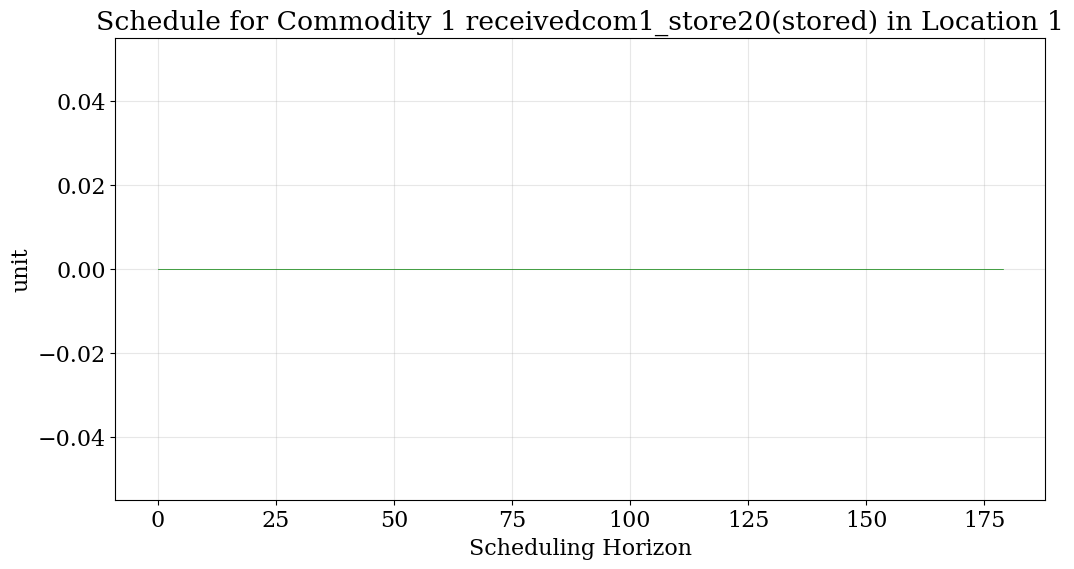

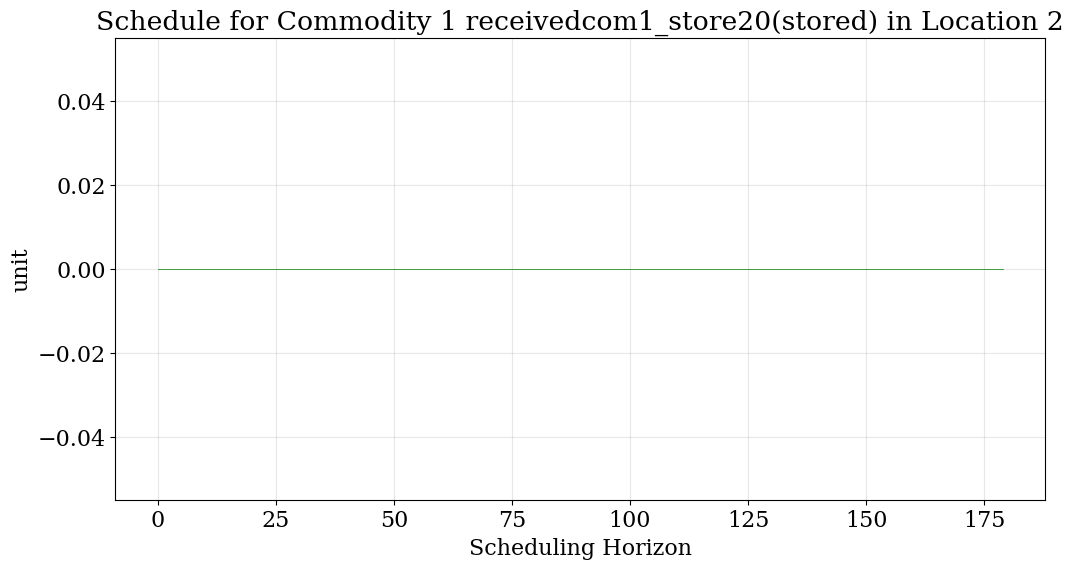

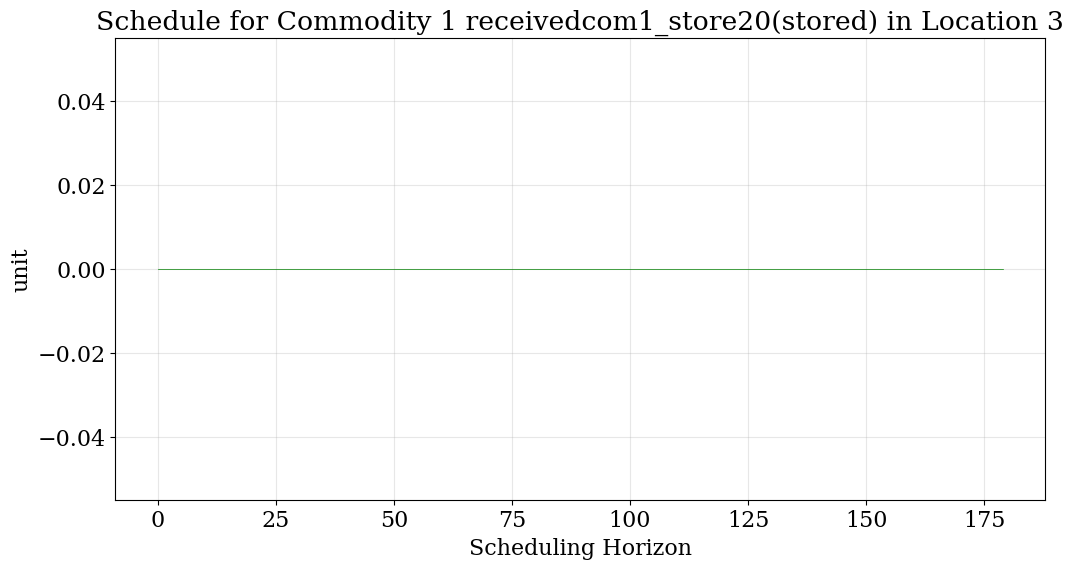

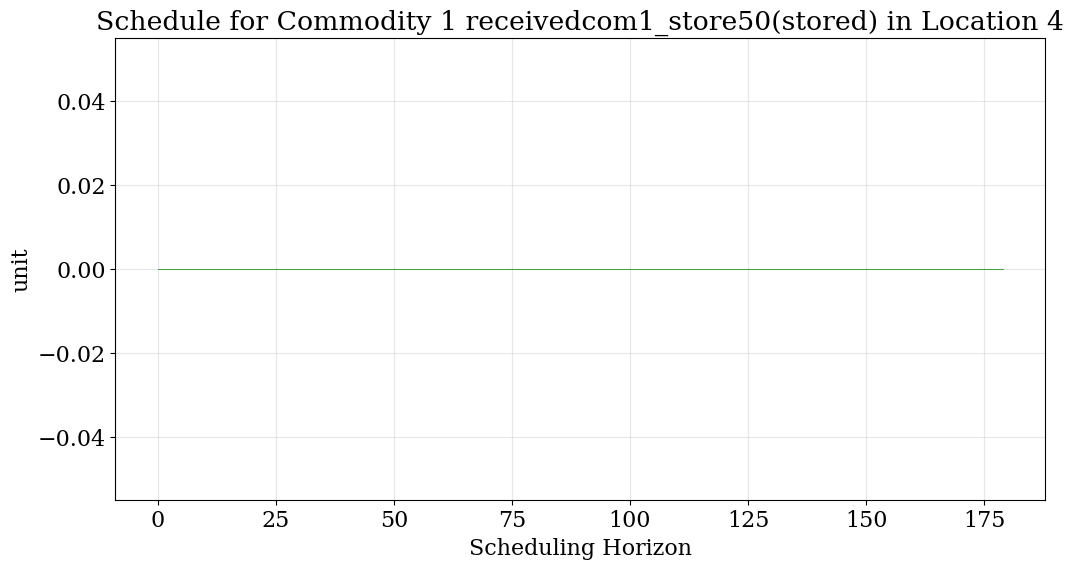

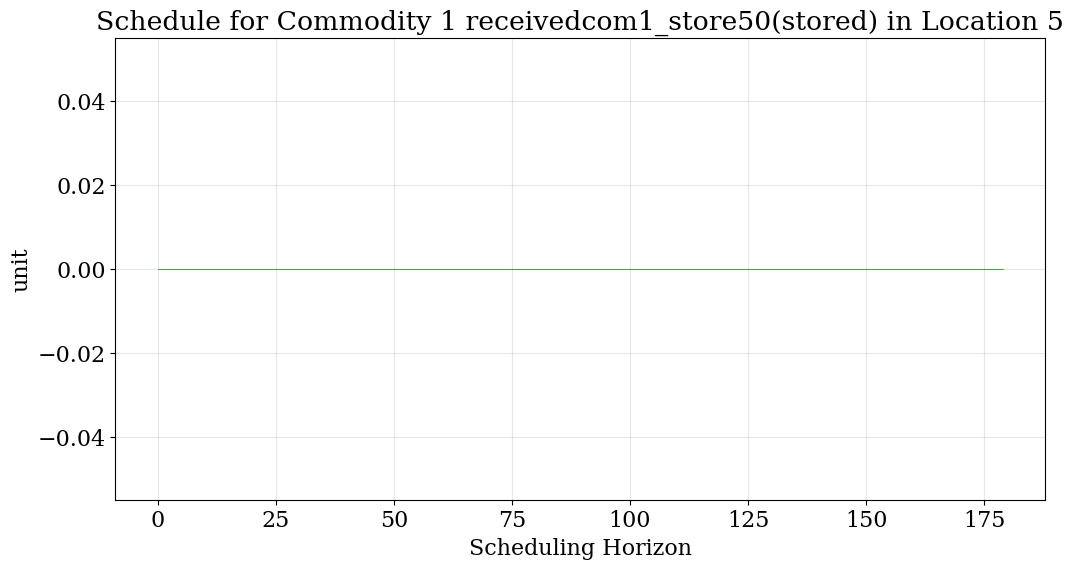

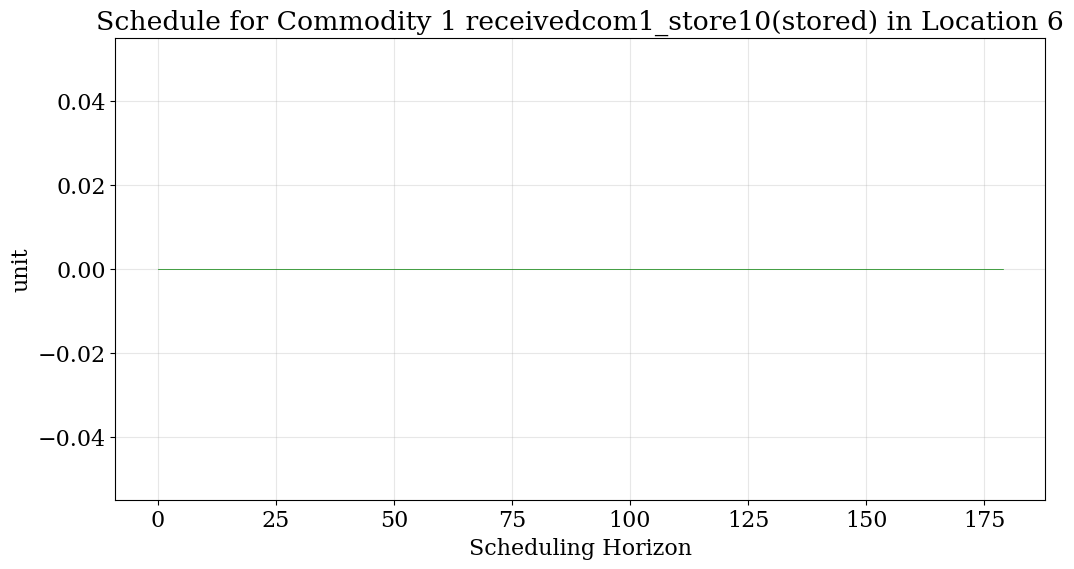

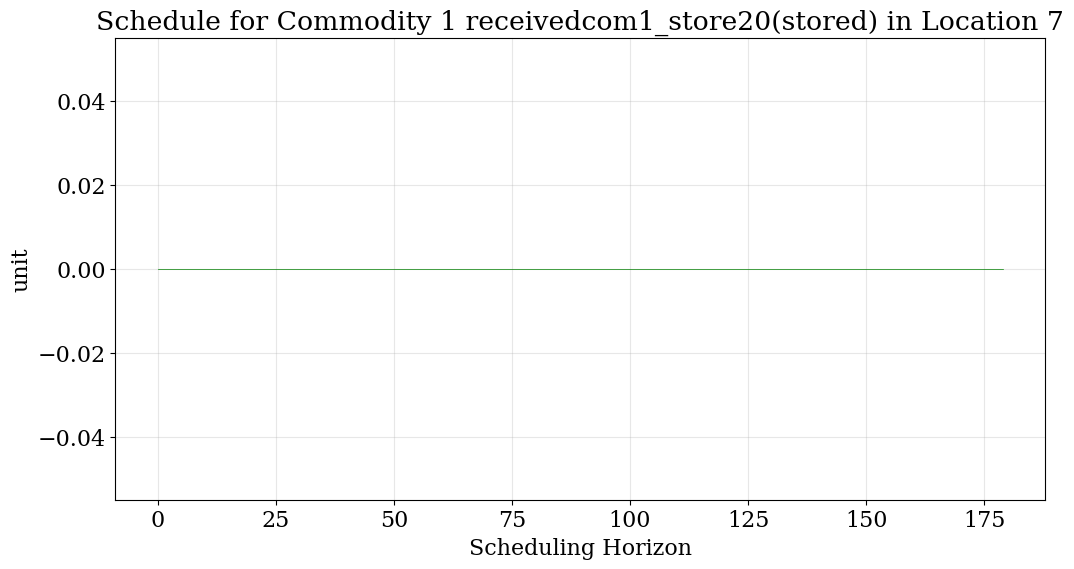

In [46]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

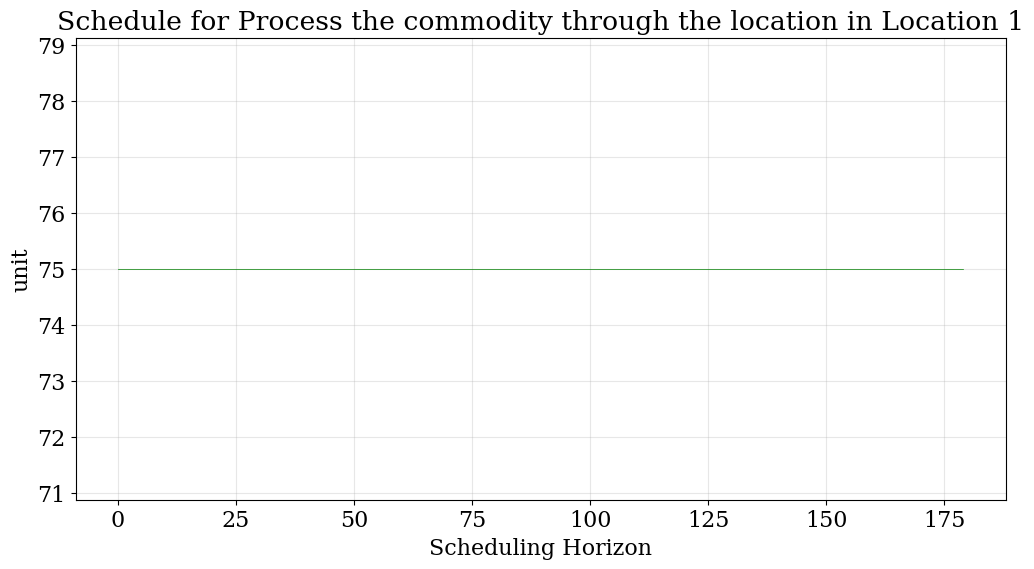

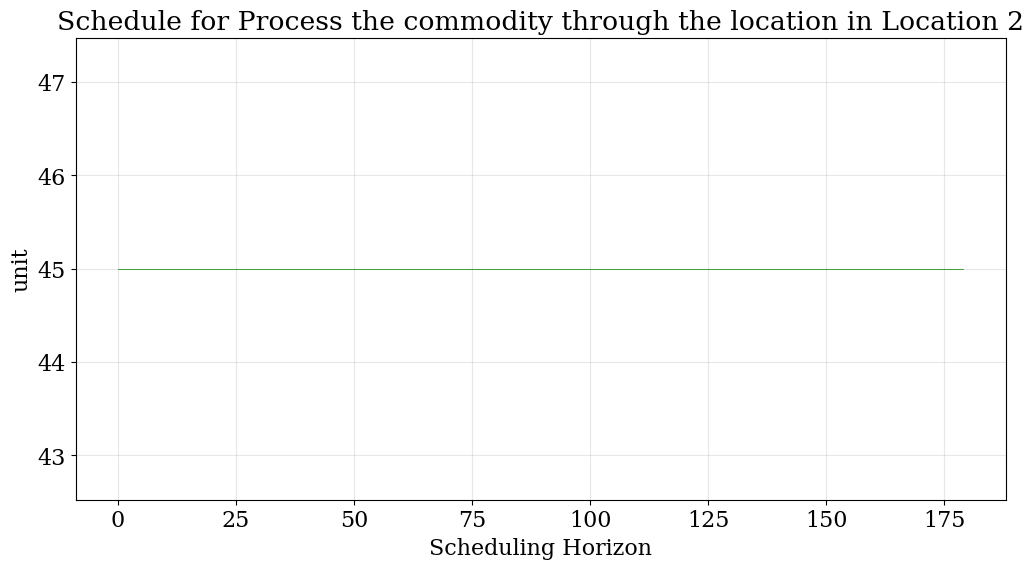

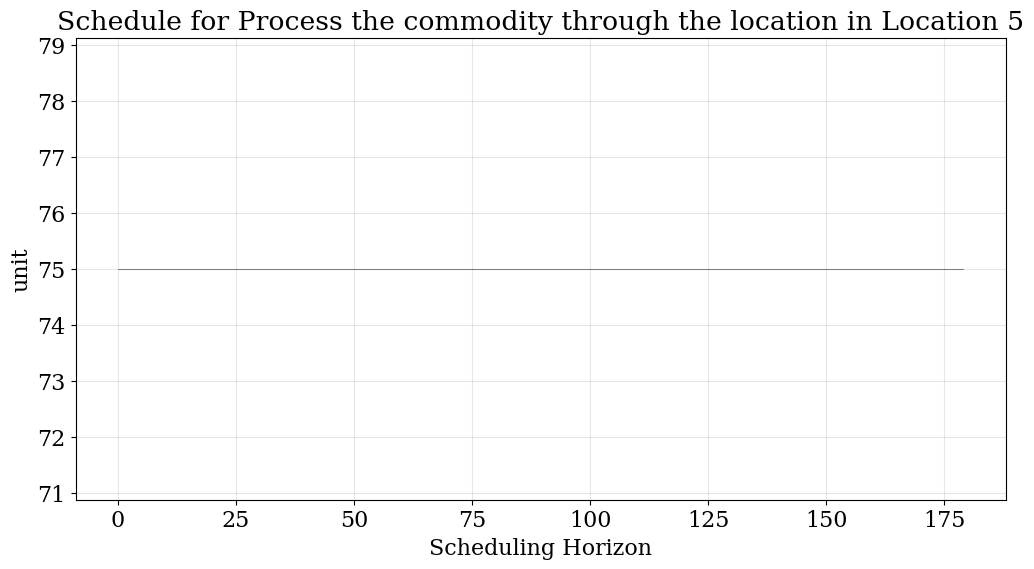

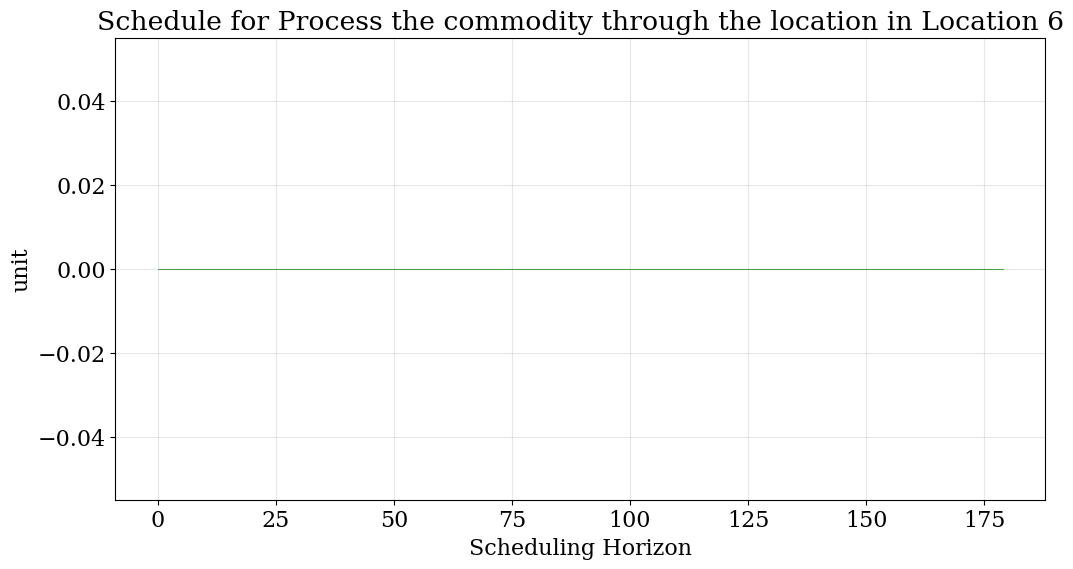

In [47]:
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc7', color='green')

In [48]:
results_mincost.output['objective']

887817.236

In [49]:
demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items()) + problem_mincost.Capex_network[0].value + problem_mincost.Vopex_network[0].value + problem_mincost.Capex_transport_network[0].value + problem_mincost.Vopex_transport_network[0].value + problem_mincost.Inv_cost_network[0].value

887817.236

In [50]:
total_vopex_cost = demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items()) + problem_mincost.Vopex_network[0].value + problem_mincost.Vopex_transport_network[0].value + problem_mincost.Inv_cost_network[0].value

total_vopex_cost

625140.0

In [51]:
demand_penalty*sum(value for key, value in results_mincost.output['Demand_penalty'].items())

450000.0

In [52]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()
problem_mincost.Inv_cost_network.pprint()

Capex_network : Capex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value    : Upper : Fixed : Stale : Domain
      0 :     0 : 237545.5 :  None : False : False : NonNegativeReals
Fopex_network : Fixed Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False : False : NonNegativeReals
Vopex_network : Variable Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value  : Upper : Fixed : Stale : Domain
      0 :     0 : 1674.0 :  None : False : False : NonNegativeReals
Capex_transport_network : overall capex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 25131.735999999997 :  None : False : False : NonNegativeReals
Fopex_transport_network : overall fopex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value :

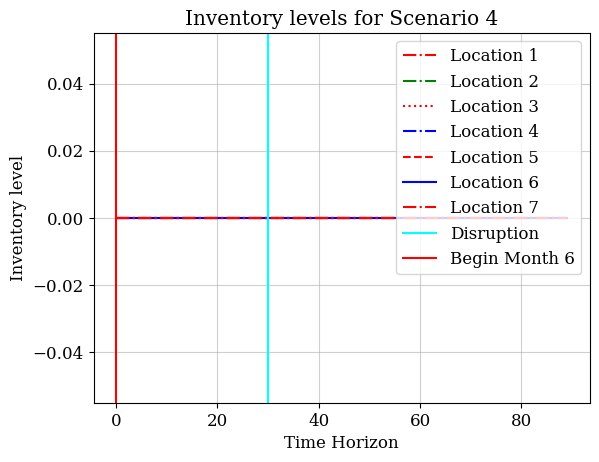

In [58]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)
fig, ax = plt.subplots()

# Plot data from the first dataset

key1 = 0
key2 = 2
start=key1*_time_intervals

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored' and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored' and key[3]>=key1 and key[3]<=key2), label='Location 1', color='red', linestyle='-.')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 2', color='green', linestyle='-.')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 3', color='red', linestyle=':')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 4', color='blue', linestyle='-.')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 5', color='red', linestyle='--')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 6', color='blue', linestyle='-')

ax.plot(range(start, len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'and key[3]>=key1 and key[3]<=key2))+start), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store10_com1_in_stored'and key[3]>=key1 and key[3]<=key2), label='Location 7', color='red', linestyle='-.')

plt.axvline(x = 30, color = 'cyan', label = 'Disruption', linestyle = '-')
plt.axvline(x = 0, color = 'red', label = 'Begin Month 6', linestyle = '-')


# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Scenario 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.6)
plt.rcdefaults()
# Show the plot
plt.show()

In [54]:
228528.0 + total_vopex_cost + 2.2425

853670.2425

In [55]:
(18000+sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold'))/36000

0.875

In [56]:
(853670.24-825643.28)/825643.28

0.033945604208151445